In [ ]:
import numpy as np
import tensorflow as tf

np.random.seed(778)
tf.random.set_seed(778)
class Individual:

    def __init__(self, num_of_features, num_of_classes, model=None, vector=None):
        self.fitness = None
        self.set_model(model, num_of_features, num_of_classes)
        if vector is not None:
            self.vector = vector
            self.decode()
        else:
            self.encode()

    def set_model(self, model, num_of_features=0, num_of_classes=0):
        if model is None:
            model = tf.keras.Sequential([
                tf.keras.layers.Dense(num_of_features * 2 + 1, activation='relu', input_shape=(num_of_features,))
            ])

            if num_of_classes == 2:
                model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
            else:
                model.add(tf.keras.layers.Dense(num_of_classes, activation='softmax'))

            self.model = model
        else:
            self.model = tf.keras.models.clone_model(model)

    def encode(self):
        self.vector = np.concatenate([w.ravel() for w in self.model.get_weights()])

    def decode(self):
        weights_and_biases = []
        idx = 0
        for layer in self.model.layers:
            weight_shape = layer.get_weights()[0].shape
            bias_shape = layer.get_weights()[1].shape
            weight_size = np.prod(weight_shape)
            bias_size = np.prod(bias_shape)
            weights_and_biases.extend([self.vector[idx:idx + weight_size].reshape(weight_shape),
                                       self.vector[idx + weight_size:idx + weight_size + bias_size].reshape(bias_shape)])
            idx += weight_size + bias_size
        self.model.set_weights(weights_and_biases)

    def evaluate(self, x, y, batch_size=16):
        if self.fitness is not None:
            return self.fitness

        predictions = self.model.predict(x, batch_size=batch_size)
        output_activation = self.model.layers[-1].activation


        if output_activation == tf.keras.activations.softmax:
            predictions = tf.argmax(predictions, axis=1)
        elif output_activation == tf.keras.activations.sigmoid:
            predictions = tf.cast(tf.round(predictions), tf.int32)




        num_correct = np.sum(predictions == y)
        p=len(y)
        #print((predictions.numpy() == y))
        self.fitness = (100 / p) * num_correct
        #print("hi",num_correct)
        #self.fitness = num_correct/p
        #self.fitness  = self.fitness.numpy()
        return self.fitness


In [ ]:
import numpy as np

class Population:
    def __init__(self, num_of_features, num_of_classes, X_train, y_train, X_val, y_val, iter=150, np=50, jr=0.5, cr=0.5, n=5, f=0.5):
        self.iter = iter
        self.np = np
        self.jr = jr
        self.cr = cr
        self.n = n
        self.f = f
        self.num_of_features = num_of_features
        self.num_of_classes = num_of_classes
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.history = []
        self.best_fitness_history = []
        self.mean_fitness_history = []
        self.centroid_history = []
        self.x_best_idx = 0
        self.x_best = None

    def mutation(self, off_spring, target, x_best, f_min=0.1, f_max=0.9):
        r1, r2 = np.random.choice(self.np, size=2, replace=False)
        xr1 = off_spring[r1]
        xr2 = off_spring[r2]
        f = f_min + np.random.rand() * (f_max - f_min)  # Adaptive mutation rate
        mutated_vector = np.array(target.vector + f * (x_best.vector - target.vector) + f * (xr1.vector - xr2.vector))
        mutated = Individual(num_of_features=self.num_of_features, num_of_classes=self.num_of_classes, vector=mutated_vector)
        return mutated

    def selection(self, off_spring):
        if np.random.random() < self.jr:
            vectors = np.array([individual.vector for individual in off_spring])
            l = np.min(vectors, axis=0)
            u = np.max(vectors, axis=0)
            off_spring = self.OBL(len(vectors[0]), off_spring, l, u, off_spring[0].model)
        else:
            sorted_indices = np.argsort([individual.evaluate(self.X_train, self.y_train) for individual in off_spring])
            sorted_offspring = [-off_spring[i] for i in sorted_indices[:self.np]]
            centroid = np.mean([individual.vector for individual in sorted_offspring[:self.n]], axis=0)
            centroid = Individual(self.num_of_features, self.num_of_classes, off_spring[0].model, centroid)
            off_spring[-1] = centroid
            self.centroid_history.append(centroid.evaluate(self.X_train, self.y_train))
        return off_spring

    def cross_over(self, target_vector, mutated_vector):
        d = len(target_vector.vector)
        jrand = np.random.randint(0, d)
        ui = np.zeros(d)
        for j in range(d):
            if np.random.rand() < self.cr or jrand == j:
                ui[j] = mutated_vector.vector[j]
            else:
                ui[j] = target_vector.vector[j]
        ui = Individual(self.num_of_features, self.num_of_classes, target_vector.model, ui)
        return ui

    def start(self):
        off_spring = [Individual(num_of_features=self.num_of_features, num_of_classes=self.num_of_classes) for _ in range(self.np)]
        d = len(off_spring[0].vector)
        l = np.full(d, -3.0)
        u = np.full(d, 3.0)

        off_spring = self.OBL(d, off_spring, l, u, off_spring[0].model)
        fitnesses = [off_spring[i].evaluate(self.X_train, self.y_train) for i in range(self.np)]
        self.history.append(np.max(fitnesses))
        self.best_fitness_history.append(np.max(fitnesses))
        self.mean_fitness_history.append(np.mean(fitnesses))
        self.x_best_idx = np.argmax(fitnesses)
        self.x_best = off_spring[self.x_best_idx]
        self.x_best.fitness = None
        self.x_best.evaluate(self.X_val, self.y_val)
        idx = 0
        target_list = np.random.permutation(self.np - 1)

        # Update self.x_best with the best individual
        best_fitness_idx = np.argmax(fitnesses)
        self.x_best = off_spring[best_fitness_idx]

        for nfe in range(self.iter):
            if idx == self.np - 1:
                target_list = np.random.permutation(self.np - 1)
                idx = 0

            target_vector = off_spring[target_list[idx % self.np - 1]]
            fitness = [individual.evaluate(self.X_train, self.y_train) for individual in off_spring]
            self.x_best_idx = np.argsort(fitness)[self.np - 1]
            x_best = off_spring[self.x_best_idx]
            mutated_vector = self.mutation(off_spring, target_vector, x_best)

            ui = self.cross_over(target_vector, mutated_vector)

            if ui.evaluate(self.X_train, self.y_train) > target_vector.evaluate(self.X_train, self.y_train):
                off_spring[target_list[idx]] = ui

            idx += 1

            off_spring = self.selection(off_spring)
            fitnesses = [off_spring[i].evaluate(self.X_train, self.y_train) for i in range(self.np)]
            self.history.append(np.max(fitnesses))
            self.best_fitness_history.append(np.max(fitnesses))
            self.mean_fitness_history.append(np.mean(fitnesses))

            # Evaluate the best individual from offspring on validation data
            best_offspring_idx = np.argmax(fitnesses)
            best_offspring = off_spring[best_offspring_idx]
            old_fitness = best_offspring.fitness
            best_offspring.fitness=None
            best_offspring_val_fitness = best_offspring.evaluate(self.X_val, self.y_val)

            # Update self.best if the best individual from offspring is better
            if best_offspring_val_fitness > self.x_best.evaluate(self.X_val, self.y_val):
                self.x_best = best_offspring
            best_offspring.fitness = old_fitness
        self.x_best_idx = np.argsort(fitness)[self.np - 1]
        return off_spring[self.x_best_idx]

    def OBL(self, d, Pop, L, U, model):
        OP_op = np.random.uniform((L + U) / 2, L + U - Pop[0].vector, (self.np, d))  # Dynamic bounds
        opposite_individual = [Individual(num_of_features=self.num_of_features, num_of_classes=self.num_of_classes, vector=vector) for vector in OP_op]
        new_population = [Pop[i] if Pop[i].evaluate(self.X_train, self.y_train) > opposite_individual[i].evaluate(self.X_train, self.y_train)
                          else opposite_individual[i] for i in range(self.np)]
        random_idx = np.random.randint(self.np - 1)
        if random_idx == self.x_best_idx:
            random_idx = (random_idx + 1) % self.np - 1
        new_population[random_idx] = opposite_individual[random_idx]
        return new_population


In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Encode the target labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)




# Create an instance of the Individual class
num_of_features = X_train.shape[1]
num_of_classes = len(np.unique(y_train))
individual = Individual(num_of_features, num_of_classes)

# Train the model (this will also decode the weights)
individual.decode()

# Evaluate the model on the test set
num_correct = individual.evaluate(X_test, y_test)
print("Fitness:", num_correct)


2/2 [==============================] - 0s 11ms/step
Fitness: 3.3333333333333335


In [ ]:
num_of_features = X_train.shape[1]
num_of_classes = len(np.unique(y_train))
pop = Population(num_of_features,num_of_classes,X,y,X_test,y_test)
pop.start()

2/2 [==============================] - 0s 5ms/step


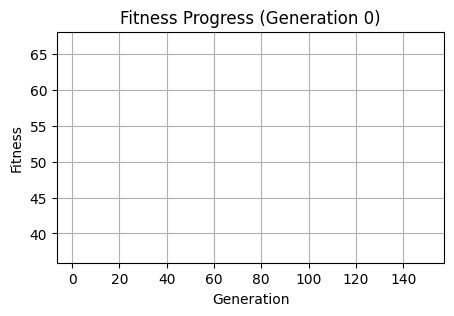

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

generations = range(1, len(pop.mean_fitness_history) + 1)
fitness_values = pop.mean_fitness_history

# Create a figure and axis
fig, ax = plt.subplots(figsize=(5, 3))
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness')
ax.set_title('AVG Fitness CenDE_OBL (iris)')

# Function to update the plot for each frame
def update_plot(frame):
    ax.clear()
    ax.plot(generations[:frame], fitness_values[:frame], marker='o')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness')
    ax.set_title(f'Fitness Progress (Generation {frame})')
    ax.grid(True)

# Create the animation
ani = animation.FuncAnimation(fig, update_plot, frames=len(generations), interval=200, repeat=False)

# Display the animation
HTML(ani.to_jshtml())


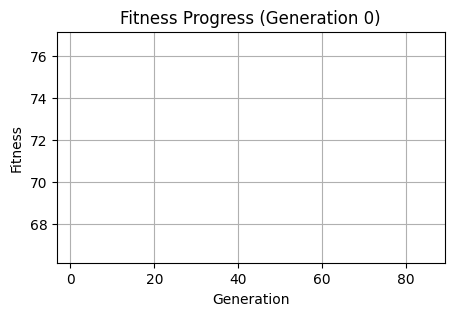

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

generations = range(1, len(pop.best_fitness_history) + 1)
fitness_values = pop.best_fitness_history

# Create a figure and axis
fig, ax = plt.subplots(figsize=(5, 3))
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness')
ax.set_title('MAX Fitness CenDE_OBL (iris)')

# Function to update the plot for each frame
def update_plot(frame):
    ax.clear()
    ax.plot(generations[:frame], fitness_values[:frame], marker='o')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness')
    ax.set_title(f'Fitness Progress (Generation {frame})')
    ax.grid(True)

# Create the animation
ani = animation.FuncAnimation(fig, update_plot, frames=len(generations), interval=200, repeat=False)

# Display the animation
HTML(ani.to_jshtml())


In [ ]:
best_nn = pop.x_best

In [ ]:
best_nn.fitness = None
best_nn.evaluate(X_test,y_test)

2/2 [==============================] - 0s 10ms/step


50.0

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
names = ['id', 'clump_thickness', 'uniformity_cell_size', 'uniformity_cell_shape', 'marginal_adhesion',
         'single_epithelial_size', 'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class']
df = pd.read_csv(url, names=names)

# Preprocessing
# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

# Convert bare_nuclei column to numeric
df['bare_nuclei'] = pd.to_numeric(df['bare_nuclei'])

# Impute missing values with median
imputer = SimpleImputer(strategy='median')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df['class'] = df['class'].map({2: 0, 4: 1})
# Split features and target
X = df.drop(['id', 'class'], axis=1)
y = df['class']
y = np.array(y)
y = y.reshape(-1,1)
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
num_of_features = X_train.shape[1]
num_of_classes = len(np.unique(y_train))
individual = Individual(num_of_features, num_of_classes)

# Train the model (this will also decode the weights)
individual.decode()

# Evaluate the model on the test set
num_correct = individual.evaluate(X_train, y_train,16)
print("Fitness:", num_correct)

8/8 [==============================] - 0s 1ms/step
Fitness: 53.333333333333336


In [ ]:
len(X_train)

559

In [ ]:
len(X)

699

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Encode the target labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)




# Create an instance of the Individual class
num_of_features = X_train.shape[1]
num_of_classes = len(np.unique(y_train))
individual = Individual(num_of_features, num_of_classes)

# Train the model (this will also decode the weights)
individual.decode()

# Evaluate the model on the test set
num_correct = individual.evaluate(X_test, y_test)
print("Fitness:", num_correct)


2/2 [==============================] - 1s 16ms/step
Fitness: 36.66666666666667


In [ ]:
num_of_features = X_train.shape[1]
num_of_classes = len(np.unique(y_train))
pop = Population(num_of_features,num_of_classes,X,y)
pop.start()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(pop.max_history)), pop.max_history, label='Max Fitness')
plt.title('CensDE_OBL MAX Fitness (iris)')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(pop.avg_history)), pop.avg_history, label='AVG Fitness')
plt.title('CensDE_OBL AVG Fitness (iris)')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"].astype(np.uint8)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y,random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Create an instance of the Individual class
num_of_features = X_train.shape[1]
num_of_classes = len(np.unique(y_train))
individual = Individual(num_of_features, num_of_classes)

# Train the model (this will also decode the weights)
individual.decode()

# Evaluate the model on the test set
num_correct = individual.evaluate(X_test, y_test)
print("Fitness:", num_correct)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
Exception ignored in: <function _xla_gc_callback at 0x7893a3cc1ab0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


2188/2188 [==============================] - 4s 2ms/step
Fitness: 12.657142857142857


In [ ]:
num_of_features = X_train.shape[1]
num_of_classes = len(np.unique(y_train))
individual = Individual(num_of_features, num_of_classes)

# Train the model (this will also decode the weights)
individual.decode()

# Evaluate the model on the test set
num_correct = individual.evaluate(X_train, y_train,16)
print("Fitness:", num_correct)

In [ ]:
num_of_features = X_train.shape[1]
num_of_classes = len(np.unique(y_train))
individual = Individual(num_of_features, num_of_classes)

# Train the model (this will also decode the weights)
individual.decode()

# Evaluate the model on the test set
num_correct = individual.evaluate(X_train, y_train,16)
print("Fitness:", num_correct)

In [ ]:
num_of_features = X_train.shape[1]
num_of_classes = len(np.unique(y_train))
pop = Population(num_of_features,num_of_classes,X,y)
best_nn = pop.start()

Streaming output truncated to the last 5000 lines.
44/44 [==============================] - 0s 2ms/step
[89.55650929899858, 89.84263233190272, 89.69957081545066, 89.4134477825465, 89.69957081545066, 89.55650929899858, 89.4134477825465, 89.84263233190272, 89.27038626609443, 89.55650929899858, 89.84263233190272, 89.4134477825465, 89.69957081545066, 89.84263233190272, 89.69957081545066, 89.55650929899858, 89.69957081545066, 89.55650929899858, 89.69957081545066, 89.4134477825465, 89.69957081545066, 89.4134477825465, 89.69957081545066, 89.69957081545066, 89.69957081545066, 89.84263233190272, 89.69957081545066, 89.4134477825465, 89.55650929899858, 89.4134477825465, 89.69957081545066, 89.69957081545066, 89.69957081545066, 89.69957081545066, 89.69957081545066, 89.69957081545066, 89.4134477825465, 89.9856938483548, 89.55650929899858, 89.55650929899858, 89.4134477825465, 89.69957081545066, 89.4134477825465, 89.55650929899858, 89.69957081545066, 89.69957081545066, 89.84263233190272, 89.6995708154

In [ ]:
pop.max_history

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(pop.max_history)), pop.max_history, label='Max Fitness')
plt.title('Fitness Convergence')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.grid(True)
plt.show()

151

In [ ]:
predictions = best_nn.model.predict(X_test)


5/5 [==============================] - 0s 2ms/step


In [ ]:
predictions

array([[0.4371006 ],
       [0.47280797],
       [0.4876006 ],
       [0.47397643],
       [0.41793826],
       [0.4306345 ],
       [0.4810784 ],
       [0.49020427],
       [0.46784863],
       [0.47280797],
       [0.46204942],
       [0.4593615 ],
       [0.4574051 ],
       [0.48467615],
       [0.45860094],
       [0.45541003],
       [0.46886364],
       [0.49516845],
       [0.49351284],
       [0.48257253],
       [0.48944545],
       [0.47995126],
       [0.4399775 ],
       [0.47280797],
       [0.46189803],
       [0.47280797],
       [0.48325777],
       [0.44328526],
       [0.4930724 ],
       [0.42578632],
       [0.5008658 ],
       [0.44776246],
       [0.42917255],
       [0.47280797],
       [0.48199475],
       [0.42184705],
       [0.4481885 ],
       [0.47834644],
       [0.48513812],
       [0.47280797],
       [0.4552425 ],
       [0.4754949 ],
       [0.4805828 ],
       [0.47638747],
       [0.48570716],
       [0.46935686],
       [0.4673317 ],
       [0.484

In [ ]:
num_correct =np.sum(np.equal(predictions, y_test))

ValueError: Data must be 1-dimensional, got ndarray of shape (140, 140) instead

In [ ]:
predictions

array([[0.48834935],
       [0.48752782],
       [0.48545465],
       [0.43662018],
       [0.48545465],
       [0.48354837],
       [0.500142  ],
       [0.37773705],
       [0.44914553],
       [0.4912327 ],
       [0.4850011 ],
       [0.45374715],
       [0.48760435],
       [0.48645028],
       [0.48760435],
       [0.39541075],
       [0.48829517],
       [0.33129117],
       [0.4221709 ],
       [0.45830074],
       [0.27262062],
       [0.486498  ],
       [0.4725954 ],
       [0.48829517],
       [0.40493646],
       [0.483536  ],
       [0.48822868],
       [0.40008923],
       [0.4934983 ],
       [0.46424246],
       [0.48960027],
       [0.48388323],
       [0.48752782],
       [0.45573267],
       [0.48829517],
       [0.48944712],
       [0.4882727 ],
       [0.2868481 ],
       [0.4881608 ],
       [0.33578166],
       [0.4850011 ],
       [0.47210464],
       [0.38523057],
       [0.48775747],
       [0.48760435],
       [0.48750937],
       [0.48957667],
       [0.470

In [ ]:
num_correct

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [ ]:
pop

AttributeError: 'Population' object has no attribute 'vector'

In [ ]:
pop.evaluate(X,y)

AttributeError: 'numpy.ndarray' object has no attribute 'evaluate'

In [ ]:
# Assuming population object is stored in a variable named 'pop'
import matplotlib.pyplot as plt

plt.plot(pop.history)
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.title("Training Progress")
plt.show()


In [ ]:
            model = tf.keras.Sequential([
                tf.keras.layers.Dense(5, activation='relu', input_shape=(num_of_features,)),
                tf.keras.layers.Dense(5, activation='relu')
            ])

            if num_of_classes == 2:
                model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
            else:
                model.add(tf.keras.layers.Dense(num_of_classes, activation='softmax'))



In [ ]:
model.get_weights()

[array([[ 0.7720841 ,  0.5134467 , -0.5080159 , -0.21719438, -0.7287278 ],
        [ 0.34269118, -0.48345652,  0.35013974,  0.21709025,  0.61095643],
        [-0.2826503 ,  0.5625522 ,  0.42432046, -0.13690764, -0.39624256],
        [-0.63163775, -0.21250206,  0.1350624 ,  0.01866341,  0.5478817 ]],
       dtype=float32),
 array([0., 0., 0., 0., 0.], dtype=float32),
 array([[ 0.10294461,  0.19192356,  0.13323593, -0.31465054,  0.30998266],
        [ 0.5706582 ,  0.41750503,  0.5143683 , -0.09496009, -0.5736913 ],
        [ 0.50468874,  0.1766721 ,  0.33680713,  0.24011862,  0.07860792],
        [ 0.18174553, -0.30327713,  0.3959862 ,  0.66552246, -0.05060589],
        [-0.37515962, -0.6392456 ,  0.23651803,  0.05346709, -0.66378975]],
       dtype=float32),
 array([0., 0., 0., 0., 0.], dtype=float32),
 array([[ 0.6209045 , -0.7962826 , -0.5479673 ],
        [-0.55694115, -0.48916605, -0.12594634],
        [-0.22796309,  0.7344598 ,  0.5418448 ],
        [ 0.5653216 ,  0.66415244,  0.39